In [1]:
import tensorflow as tf
from modules.metropolis import *
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from collections import Counter

@dataclass
class TestProblem(QFTProblem):
    size: tuple[float, float] = (10, 100)

    def volume(self) -> npt.NDArray:
        return np.array(self.size)

    def get_amplitude(self, x_n: tf.Tensor, ns: npt.NDArray, training: bool = False) -> tf.Tensor:
        mask = tf.sequence_mask(ns, maxlen = x_n.shape[-2])

        mask = tf.cast(mask, x_n.dtype)
        masked_sin = tf.where(mask > 0, tf.sin(x_n[:, :, 0]) * tf.sin(x_n[:, :, 1] / 20), tf.ones_like(x_n[:, :, 0])) # type: ignore
        profile = tf.pow(tf.reduce_prod(masked_sin, axis=1), 2)

        ns = tf.cast(ns, x_n.dtype) # type: ignore

        return profile * np.exp(-ns / 10.) / np.power(np.prod(self.volume()), ns / 2.) * (0.1 + ns)

In [2]:
test_problem = TestProblem()

metropolis = FockSpaceMetropolis(test_problem, 5, rng=np.random.default_rng(0))

x_n, ampilitude = metropolis.new_configuration(2, 2)
print("initial\n", x_n)

x_add = metropolis.add_new(x_n)
print("add new\n", x_add)

x_remove = metropolis.remove_one(x_n)
print("remove one\n", x_remove)
            
x_changed = metropolis.change_positions(x_n)
print("change position\n", x_changed)

x_changed = metropolis.change_positions(x_n)
print("change position\n", x_changed)

x_step, _ = metropolis.step(x_n, ampilitude)
print("step one\n", x_step)
x_n, _ = metropolis.new_configuration(2, 0)
print("initial\n", x_n)

x_remove = metropolis.remove_one(x_n)
print("remove one\n", x_remove)

x_add = metropolis.add_new(x_n)
print("add new\n", x_add)


initial
 ConfigurationBatch(x_n=array([[[ 6.36961687, 26.97867138],
        [ 0.40973524,  1.65276355],
        [ 8.13270239, 91.27555773],
        [ 6.06635776, 72.9496561 ],
        [ 5.43624991, 93.50724238]],

       [[ 8.15853554,  0.27385002],
        [ 8.57404277,  3.35855753],
        [ 7.29655446, 17.56556206],
        [ 8.63178922, 54.14612202],
        [ 2.99711891, 42.26872212]]]), n_s=array([2, 2], dtype=int32))
add new
 ConfigurationBatch(x_n=array([[[ 6.36961687, 26.97867138],
        [ 0.40973524,  1.65276355],
        [ 0.28319671, 12.42832765],
        [ 6.06635776, 72.9496561 ],
        [ 5.43624991, 93.50724238]],

       [[ 8.15853554,  0.27385002],
        [ 8.57404277,  3.35855753],
        [ 6.70624415, 64.71895116],
        [ 8.63178922, 54.14612202],
        [ 2.99711891, 42.26872212]]]), n_s=array([3, 3], dtype=int32))
remove one
 ConfigurationBatch(x_n=array([[[ 6.36961687, 26.97867138],
        [ 0.40973524,  1.65276355],
        [ 8.13270239, 91.27555773],

In [4]:
import modules.metropolis as metro
import importlib
importlib.reload(metro)

batch = 32
n_max = 10

test_problem = TestProblem()
test_metropolis = metro.FockSpaceMetropolis(test_problem, n_max, rng=np.random.default_rng(0))

def metropolis_step(metropolis: FockSpaceMetropolis, batch = 32, n_init = 5):
    x_recent, amplitude_recent = metropolis.new_configuration(batch, n_init)
    while True:
        x_recent, amplitude_recent = metropolis.step(x_recent, amplitude_recent)
        yield x_recent.x_n, x_recent.n_s

dataset = tf.data.Dataset.from_generator(
    lambda: metropolis_step(test_metropolis, batch = batch),
    output_signature = (
        tf.TensorSpec(shape=(batch, n_max, 2), dtype=tf.float32, name="features"), # type: ignore
        tf.TensorSpec(shape=(batch), dtype=tf.int32) # type: ignore
    )
)


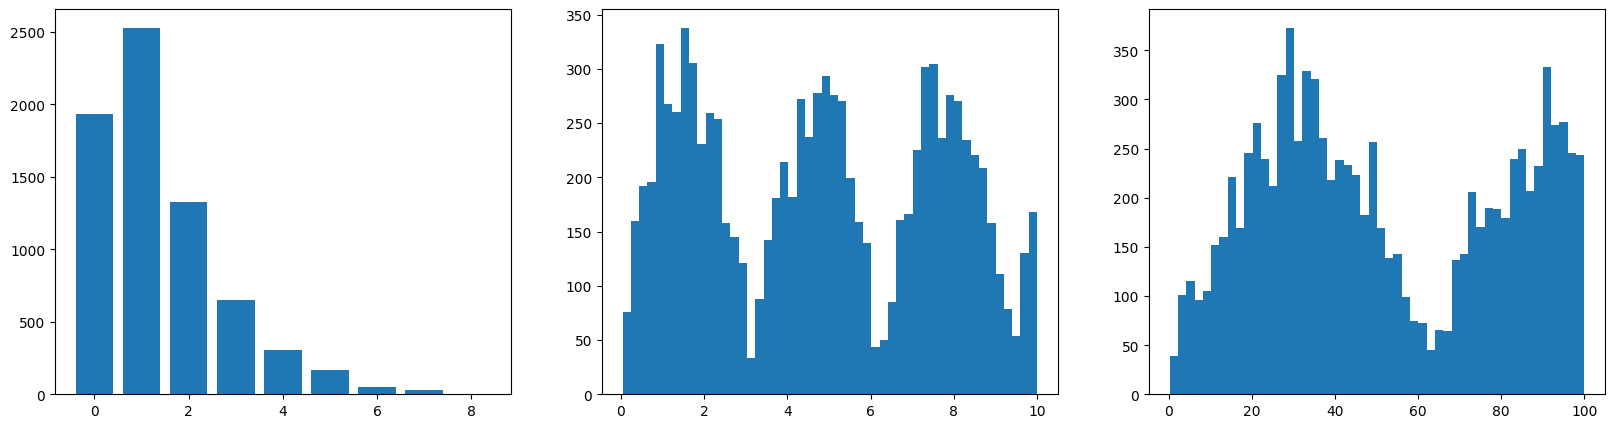

In [3]:
from collections import Counter

configurations = dataset.unbatch().skip(3000).take(7000).cache()
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

n_values = list(map(lambda x_n: x_n[1].numpy(), configurations))
n_counter = Counter(n_values)
axes[0].bar(n_counter.keys(), n_counter.values())

positions_1 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 0], configurations))).ravel()
positions_2 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 1], configurations))).ravel()

axes[1].hist(positions_1, bins=50)
axes[2].hist(positions_2, bins=50);

In [5]:
tfds.benchmark(dataset.take(10000), batch_size = batch)


************ Summary ************



0it [00:00, ?it/s]

Examples/sec (First included) 15893.58 ex/sec (total: 320032 ex, 20.14 sec)
Examples/sec (First only) 77.03 ex/sec (total: 32 ex, 0.42 sec)
Examples/sec (First excluded) 16226.76 ex/sec (total: 320000 ex, 19.72 sec)


,duration,num_examples,avg
first+lasts,20.135933,320032,15893.576999
first,0.415424,32,77.029771
lasts,19.720509,320000,16226.761610


In [6]:
with tf.GradientTape() as g2:
    with tf.GradientTape() as g:
        x_n, n_s = next(iter(configurations.batch(1).skip(40))) # type: ignore

        x_n = tf.Variable(x_n)
        print(x_n, n_s)

        value = test_problem.get_amplitude(x_n, n_s) # type: ignore

    gradient = g.gradient(value, x_n)

hessian = g2.jacobian(gradient, x_n)
# laplacian = tf.linalg.trace(laplacian)
laplacian = tf.einsum('bpibpi->bpi', hessian)

print("y", value)
print("gradient", gradient)
print("laplacian", laplacian)

<tf.Variable 'Variable:0' shape=(1, 10, 2) dtype=float32, numpy=
array([[[ 5.0902042 , 72.595436  ],
        [ 8.687788  , 43.252575  ],
        [ 0.95789915,  8.690153  ],
        [ 0.83288276, 89.49227   ],
        [ 8.087362  , 43.382     ],
        [ 1.1243632 , 23.481735  ],
        [ 9.022893  , 62.04052   ],
        [ 5.9924383 , 55.55923   ],
        [ 8.205903  , 53.68986   ],
        [ 6.432432  , 77.57588   ]]], dtype=float32)> tf.Tensor([2], shape=(1,), dtype=int32)
y tf.Tensor([0.00010165], shape=(1,), dtype=float32)
gradient tf.Tensor(
[[[-8.0685510e-05  1.9141149e-05]
  [-2.2399958e-04 -6.8329973e-06]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]]], shape=(1, 10, 2), dtype=float32)
laplacian tf.Tensor(
[[[-1.7127609e-04  1.2939470e-06]
  [ 4.3509703

In [7]:
x0 = 4.85924769
x1 = 23.90258908

print("y", np.power(np.sin(x0) * np.sin(x1 / 20), 2) * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("dy/dx0", np.sin(2 * x0) * np.sin(x1 / 20) ** 2 * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("dy/dx1", 1 / 20 * np.sin(x0) ** 2 * np.sin(2 * x1 / 20) * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("d^2y/dx0^2", 2 * np.cos(2 * x0) * np.sin(x1 / 20) ** 2 * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("d^2y/dx1^2", 1 / 200 * np.sin(x0) ** 2 * np.cos(2 * x1 / 20) * np.exp(-0.1) / np.sqrt(1000) * 1.1)

y 0.026654735548713143
dy/dx0 -0.007885733618981039
dy/dx1 0.0010512547138865212
d^2y/dx0^2 -0.05214298429068455
d^2y/dx1^2 -0.00011254309365187722


In [5]:
from importlib import reload
import modules.hamiltonians.hamiltonian_terms as terms
reload(terms)

kinetic_term = terms.KineticTerm(0.5)

x_n, n_s = next(iter(configurations.batch(4).skip(20))) # type: ignore
x_n: tf.Tensor = tf.Variable(x_n) # type: ignore

print("kinetic term")
print(kinetic_term.local_energy(x_n, n_s, test_problem))

chemical_potential = terms.ExternalPotential.chemical_potential(1)

print("Chemical potential")
print(chemical_potential.local_energy(x_n, n_s, test_problem))

NameError: name 'configurations' is not defined

# Model learning

In [6]:
import keras
import modules.ansatz_nn as ansatz_nn
from modules.hamiltonians.hamiltonian_terms import *
import importlib
importlib.reload(ansatz_nn)

input_dim = 2

ds1 = ansatz_nn.DeepSets(16, 2, 2, input_dim=input_dim, name = "deep_set_1")
ds2 = ansatz_nn.DeepSets(16, 2, 2, input_dim=input_dim, name = "deep_set_2")

hamiltonian = KineticTerm(0.5)

test_model = ansatz_nn.QFTNeuralNet(
    np.array([10, 100]), 
    ds1, 
    ds2,
    hamiltonian,
    is_periodic = True
)

dataset = metro.make_dataset(test_model, 32, 10, 5)

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} TypeError: ContactPotential.jastrow_cusp() missing 1 required positional argument: 'volume'
Traceback (most recent call last):

  File "c:\Users\marcr\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "c:\Users\marcr\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\marcr\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\marcr\Documents\vs_code\nn_qft\modules\metropolis.py", line 124, in metropolis_step
    x_recent, amplitude_recent = metropolis.new_configuration(batch, n_init)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\marcr\Documents\vs_code\nn_qft\modules\metropolis.py", line 29, in new_configuration
    ampiltude = self.problem.get_amplitude(x_n_t, configurations.n_s)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\marcr\Documents\vs_code\nn_qft\modules\ansatz_nn.py", line 116, in get_amplitude
    return self.call(x_n, ns, training = training)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\marcr\Documents\vs_code\nn_qft\modules\ansatz_nn.py", line 136, in call
    cusp = self.hamiltonian.jastrow_cusp(x_ij, mask_ij, mask_n, self.volume_arr)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\marcr\Documents\vs_code\nn_qft\modules\hamiltonians\lieb_liniger_model.py", line 16, in jastrow_cusp
    return self.contact_term.jastrow_cusp(x_ij, mask_ij, volume)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

TypeError: ContactPotential.jastrow_cusp() missing 1 required positional argument: 'volume'


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 

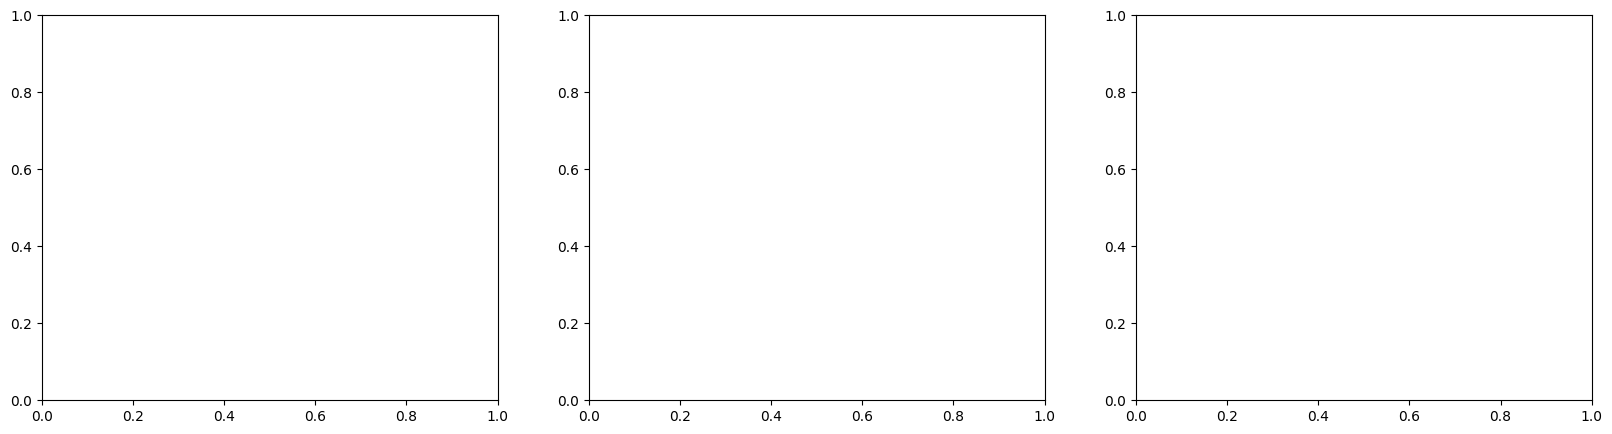

In [3]:
configurations = dataset.skip(500).unbatch().take(7000).cache()
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

n_values = list(map(lambda x_n: x_n[1].numpy(), configurations))
n_counter = Counter(n_values)
axes[0].bar(n_counter.keys(), n_counter.values())

positions_1 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 0], configurations))).ravel()
positions_2 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 1], configurations))).ravel()

axes[1].hist(positions_1, bins=50)
axes[2].hist(positions_2, bins=50);

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    1e-2,
    decay_steps = 5,
    decay_rate = 0.95,
    staircase=True
)

test_model.compile(
    optimizer = tf.keras.optimizers.Adam(lr_schedule),
)

history = test_model.fit(
    dataset.skip(500).take(1000),
    epochs = 10,
)

In [ ]:
configurations = dataset.skip(500).unbatch().take(7000).cache()
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

n_values = list(map(lambda x_n: x_n[1].numpy(), configurations))
n_counter = Counter(n_values)
axes[0].bar(n_counter.keys(), n_counter.values())

positions_1 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 0], configurations))).ravel()
positions_2 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 1], configurations))).ravel()

axes[1].hist(positions_1, bins=50)
axes[2].hist(positions_2, bins=50);

# Lieb Lieniger model

In [ ]:
import keras
import modules.ansatz_nn as ansatz_nn
from modules.hamiltonians.hamiltonian_terms import *
import modules.hamiltonians.lieb_liniger_model as ll_model
import importlib
import modules.metropolis as metro
import matplotlib.pyplot as plt
from collections import Counter
importlib.reload(ansatz_nn)
importlib.reload(ll_model)

input_dim = 1

ds1 = ansatz_nn.DeepSets(16, 2, 2, input_dim=input_dim, name = "deep_set_1")
ds2 = ansatz_nn.DeepSets(16, 2, 2, input_dim=input_dim, name = "deep_set_2")

hamiltonian = ll_model.LiebLinigerHamiltonian(0.5, (3.75 * np.pi) ** 2, 1e6)

test_model = ansatz_nn.QFTNeuralNet(
    np.array([1]), 
    ds1, 
    ds2,
    hamiltonian,
    is_periodic = False
)

dataset = metro.make_dataset(test_model, 64, 10, 5)

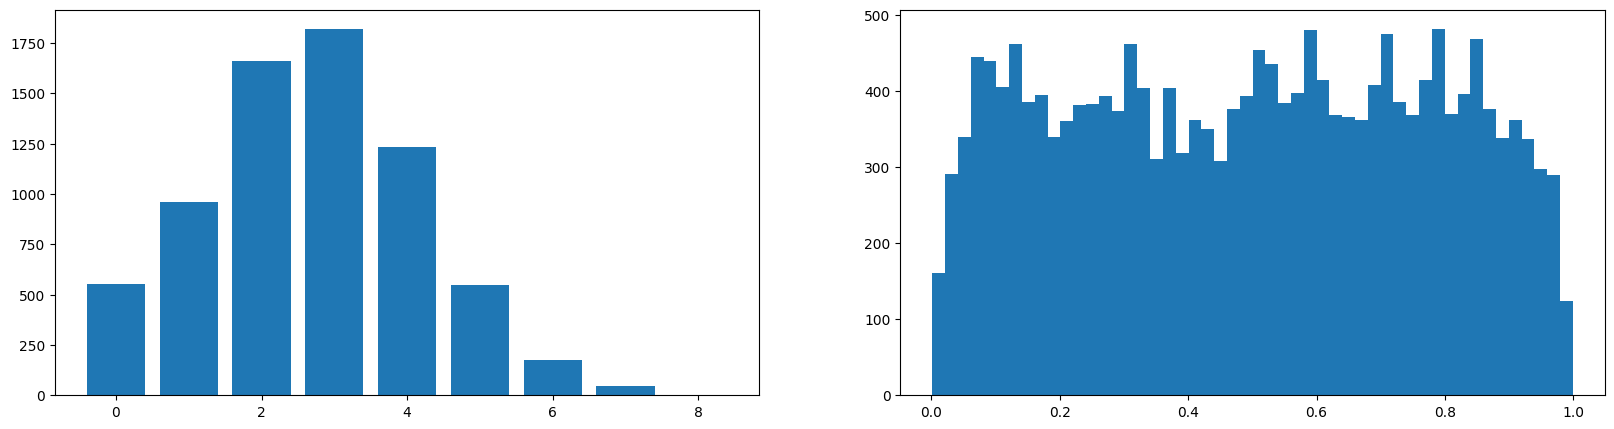

In [4]:
configurations = dataset.skip(500).unbatch().take(7000).cache()
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

n_values = list(map(lambda x_n: x_n[1].numpy(), configurations))
n_counter = Counter(n_values)
axes[0].bar(n_counter.keys(), n_counter.values())

positions_1 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 0], configurations))).ravel()

axes[1].hist(positions_1, bins=50);

In [5]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    1e-3,
    decay_steps = 50,
    decay_rate = 0.95,
    staircase=True
)

test_model.compile(
    optimizer = tf.keras.optimizers.Adam(lr_schedule),
)

history = test_model.fit(
    dataset.skip(500).take(1000),
    epochs = 500,
)

Epoch 1/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - energy: -513.4951 - loss: -513.4951 - mean_particle_number: 2.1392
Epoch 2/500


c:\Users\marcr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - energy: -502.4897 - loss: -502.4897 - mean_particle_number: 2.0725
Epoch 3/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - energy: -497.2390 - loss: -497.2390 - mean_particle_number: 2.0461
Epoch 4/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - energy: -485.2016 - loss: -485.2016 - mean_particle_number: 2.0035
Epoch 5/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - energy: -515.4330 - loss: -515.4330 - mean_particle_number: 2.1586
Epoch 6/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - energy: -503.3542 - loss: -503.3542 - mean_particle_number: 2.1019
Epoch 7/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - energy: -470.3895 - loss: -470.3895 - mean_particle_number: 2.0081
Epoch 8/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - energy: -480.8182 - loss: -480.8182 - mean_particle_number: 2.0221
Epoch 9/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - energy: -493.8365 - loss: -493.8365 - mean_particle_number: 2.0691
Epoc

KeyboardInterrupt: 

(array([148., 228., 235., 206., 293., 295., 298., 346., 299., 331., 274.,
        278., 344., 251., 269., 291., 394., 341., 314., 290., 317., 303.,
        301., 243., 266., 292., 316., 269., 262., 358., 280., 292., 338.,
        358., 317., 325., 311., 283., 231., 311., 277., 326., 272., 328.,
        253., 259., 224., 209., 168.,  78.]),
 array([4.01331228e-04, 2.03431007e-02, 4.02848721e-02, 6.02266416e-02,
        8.01684111e-02, 1.00110181e-01, 1.20051950e-01, 1.39993712e-01,
        1.59935489e-01, 1.79877266e-01, 1.99819028e-01, 2.19760790e-01,
        2.39702567e-01, 2.59644330e-01, 2.79586077e-01, 2.99527854e-01,
        3.19469631e-01, 3.39411408e-01, 3.59353185e-01, 3.79294932e-01,
        3.99236709e-01, 4.19178486e-01, 4.39120233e-01, 4.59062010e-01,
        4.79003787e-01, 4.98945564e-01, 5.18887341e-01, 5.38829088e-01,
        5.58770835e-01, 5.78712642e-01, 5.98654389e-01, 6.18596196e-01,
        6.38537943e-01, 6.58479691e-01, 6.78421497e-01, 6.98363245e-01,
        7.

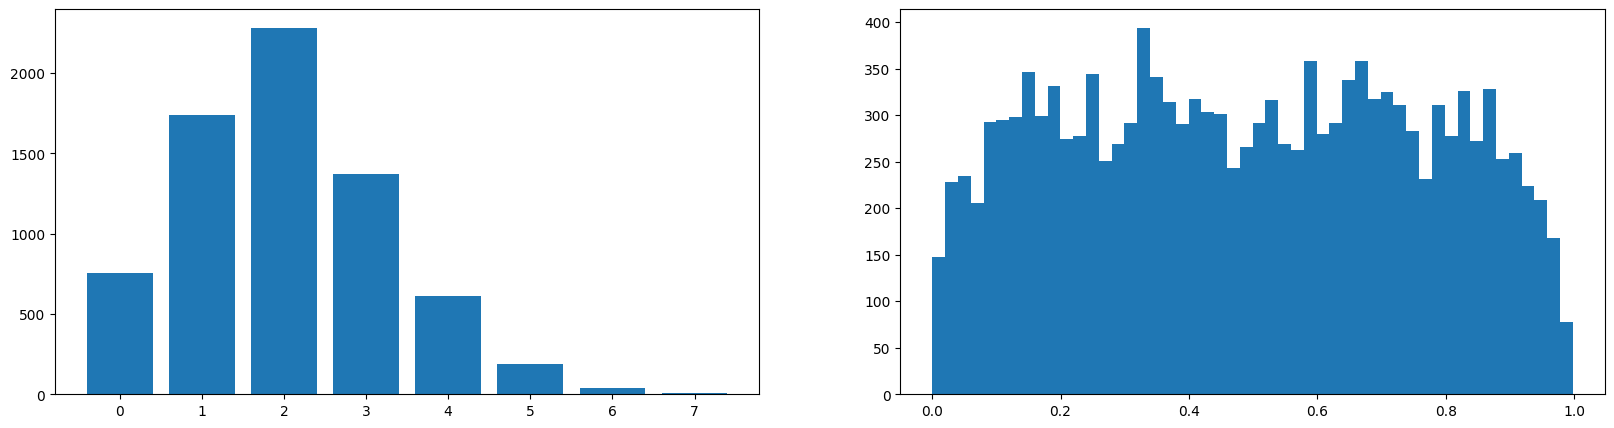

In [6]:
configurations = dataset.skip(500).unbatch().take(7000).cache()
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

n_values = list(map(lambda x_n: x_n[1].numpy(), configurations))
n_counter = Counter(n_values)
axes[0].bar(n_counter.keys(), n_counter.values())

positions_1 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 0], configurations))).ravel()

axes[1].hist(positions_1, bins=50)

In [18]:
print(test_model.weights)

[<Variable path=phi/dense_40/kernel, shape=(1, 16), dtype=float32, value=[[-0.21043459 -0.47421443  0.4473956   0.35582936 -0.31333023 -0.30545524
  -0.29382446  0.578257    0.26493168 -0.46846125 -0.05681944  0.32219625
   0.20747478  0.19191943 -0.17879593  0.24780577]]>, <Variable path=phi/dense_40/bias, shape=(16,), dtype=float32, value=[ 0.          0.          0.150722    0.11530792  0.          0.
  0.         -0.03179562  0.10659171  0.          0.          0.0623827
 -0.08554172  0.08349905  0.          0.08284459]>, <Variable path=phi/dense_41/kernel, shape=(16, 16), dtype=float32, value=[[-1.71810359e-01 -1.36402428e-01 -1.49886906e-01 -4.06204611e-01
   2.56321222e-01 -8.89329612e-02 -7.51193762e-02  1.75796300e-01
  -2.58204818e-01  1.80134386e-01 -1.75872475e-01  2.63039738e-01
   9.74101722e-02  2.56280333e-01 -9.97152627e-02  3.08212489e-01]
 [ 4.05020148e-01  3.32085937e-01 -3.32608730e-01 -5.86139560e-02
   1.84278876e-01 -1.39330328e-02  1.72194093e-01  1.53040439e-0